In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True)

train_x = train_dataset.data.unsqueeze(1).float().div(255).to('cuda')
train_y = train_dataset.targets.to('cuda')
test_x = test_dataset.data.unsqueeze(1).float().div(255).to('cuda')
test_y = test_dataset.targets.to('cuda')


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.0MB/s]


In [ ]:
import torch.nn as nn
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

class ResNetBlock1(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNetBlock2(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNetBlock3(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_of_blocks,
                 kernel_conv_size, stride_conv,
                 kernel_pool_size, stride_pool,
                 block, lin_layers):
        super(ResNet, self).__init__()
        models = \
            [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv)] + \
            [block(out_channels, out_channels)] * num_of_blocks + \
            [nn.MaxPool2d(kernel_pool_size, stride=stride_pool)] + \
            [nn.Flatten()]

        vect = torch.zeros(1, in_channels, 28, 28)
        for model in models:
            vect = model(vect)
        lin_dim = vect.shape[1]
        lin_dims = [lin_dim]
        for i in range(lin_layers - 1):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        lin_dims.append(10)
        self.model = nn.Sequential(
            *models,
            *[nn.Linear(lin_dims[i], lin_dims[i + 1]) for i in range(len(lin_dims) - 1)]
        )

    def forward(self, x):
        return self.model(x)

    def fit(self, X, Y, lr, batch_size, epochs, logs=True):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
            if logs:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    def predict(self, X):
        with torch.no_grad():
            return self(X).argmax(dim=1)


Epoch 1/10, Loss: 0.5946269035339355
Epoch 2/10, Loss: 0.4947052597999573
Epoch 3/10, Loss: 0.599396824836731
Epoch 4/10, Loss: 0.3894895315170288
Epoch 5/10, Loss: 0.22477108240127563
Epoch 6/10, Loss: 0.2082843780517578
Epoch 7/10, Loss: 0.28046542406082153
Epoch 8/10, Loss: 0.2389276623725891
Epoch 9/10, Loss: 0.4095773696899414
Epoch 10/10, Loss: 0.2797867953777313
Accuracy with block ResNetBlock1: 88.47%
Epoch 1/10, Loss: 0.37674766778945923
Epoch 2/10, Loss: 0.8113260269165039
Epoch 3/10, Loss: 0.26171571016311646
Epoch 4/10, Loss: 0.16877081990242004
Epoch 5/10, Loss: 0.4862689971923828
Epoch 6/10, Loss: 0.3728677034378052
Epoch 7/10, Loss: 0.13696232438087463
Epoch 8/10, Loss: 0.4890807569026947
Epoch 9/10, Loss: 0.19729331135749817
Epoch 10/10, Loss: 0.10662893950939178
Accuracy with block ResNetBlock2: 88.87%
Epoch 1/10, Loss: 0.4047551155090332
Epoch 2/10, Loss: 0.678288459777832
Epoch 3/10, Loss: 0.14946973323822021
Epoch 4/10, Loss: 0.32818442583084106
Epoch 5/10, Loss: 0.

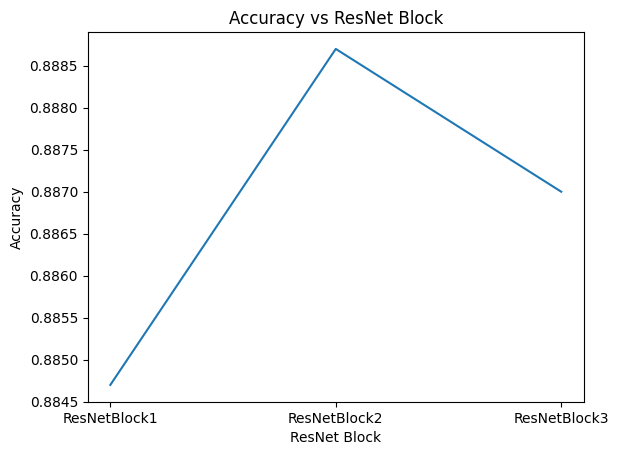

In [ ]:
blocks = [ResNetBlock1, ResNetBlock2, ResNetBlock3]
accuracy_scores = []

for block in blocks:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=1,
                   kernel_conv_size=3,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=block,
                   lin_layers=2)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with block {block.__name__}: {accuracy * 100}%')

max_block = blocks[accuracy_scores.index(max(accuracy_scores))]
print(f'Best block: {max_block.__name__}')

plt.plot([block.__name__ for block in blocks], accuracy_scores)
plt.xlabel('ResNet Block')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ResNet Block')
plt.show()

Epoch 1/10, Loss: 0.35362768173217773
Epoch 2/10, Loss: 0.5667086839675903
Epoch 3/10, Loss: 0.2571389675140381
Epoch 4/10, Loss: 0.22180837392807007
Epoch 5/10, Loss: 0.18174415826797485
Epoch 6/10, Loss: 0.5146455764770508
Epoch 7/10, Loss: 0.37560778856277466
Epoch 8/10, Loss: 0.09218849241733551
Epoch 9/10, Loss: 0.15542888641357422
Epoch 10/10, Loss: 0.17920660972595215
Accuracy with block count 1: 88.7%
Epoch 1/10, Loss: 0.2814388871192932
Epoch 2/10, Loss: 0.7784209251403809
Epoch 3/10, Loss: 0.11619850993156433
Epoch 4/10, Loss: 0.4372428059577942
Epoch 5/10, Loss: 0.2984452247619629
Epoch 6/10, Loss: 0.24356111884117126
Epoch 7/10, Loss: 0.28601938486099243
Epoch 8/10, Loss: 0.27371832728385925
Epoch 9/10, Loss: 0.2194785177707672
Epoch 10/10, Loss: 0.14477753639221191
Accuracy with block count 2: 89.69%
Epoch 1/10, Loss: 0.37932831048965454
Epoch 2/10, Loss: 0.41094326972961426
Epoch 3/10, Loss: 0.46379518508911133
Epoch 4/10, Loss: 0.2005261778831482
Epoch 5/10, Loss: 0.4663

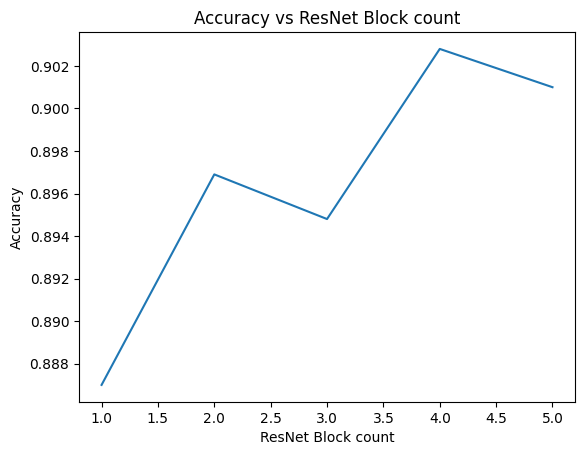

In [ ]:
block_counts = range(1, 6)
accuracy_scores = []

for block_count in block_counts:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=block_count,
                   kernel_conv_size=3,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=2)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with block count {block_count}: {accuracy * 100}%')

max_block_count = block_counts[accuracy_scores.index(max(accuracy_scores))]
print(f'Best block count: {max_block_count}')

plt.plot(block_counts, accuracy_scores)
plt.xlabel('ResNet Block count')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ResNet Block count')
plt.show()

Epoch 1/10, Loss: 0.3716198205947876
Epoch 2/10, Loss: 0.298327773809433
Epoch 3/10, Loss: 0.3873722553253174
Epoch 4/10, Loss: 0.2922109067440033
Epoch 5/10, Loss: 0.45379623770713806
Epoch 6/10, Loss: 0.2926793098449707
Epoch 7/10, Loss: 0.31615951657295227
Epoch 8/10, Loss: 0.11393304169178009
Epoch 9/10, Loss: 0.2209559679031372
Epoch 10/10, Loss: 0.2793753147125244
Accuracy with linear layer count 1: 89.21%
Epoch 1/10, Loss: 0.4274686574935913
Epoch 2/10, Loss: 0.3132261633872986
Epoch 3/10, Loss: 0.2818466126918793
Epoch 4/10, Loss: 0.4596686363220215
Epoch 5/10, Loss: 0.18527425825595856
Epoch 6/10, Loss: 0.31367722153663635
Epoch 7/10, Loss: 0.29903239011764526
Epoch 8/10, Loss: 0.10661099851131439
Epoch 9/10, Loss: 0.12843412160873413
Epoch 10/10, Loss: 0.2230657935142517
Accuracy with linear layer count 2: 90.02%
Epoch 1/10, Loss: 0.6627171039581299
Epoch 2/10, Loss: 0.4038165807723999
Epoch 3/10, Loss: 0.5535131692886353
Epoch 4/10, Loss: 0.22290009260177612
Epoch 5/10, Loss

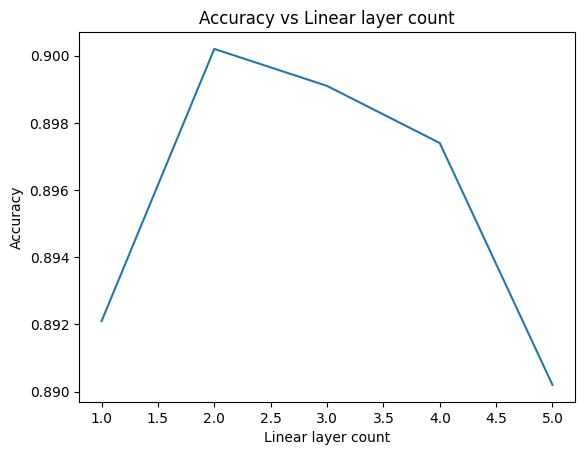

In [ ]:
lin_layer_counts = range(1, 6)
accuracy_scores = []

for lin_layer_count in lin_layer_counts:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=3,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with linear layer count {lin_layer_count}: {accuracy * 100}%')

max_lin_layer_count = lin_layer_counts[accuracy_scores.index(max(accuracy_scores))]
print(f'Best linear layer count: {max_lin_layer_count}')

plt.plot(lin_layer_counts, accuracy_scores)
plt.xlabel('Linear layer count')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Linear layer count')
plt.show()

Epoch 1/10, Loss: 0.473227858543396
Epoch 2/10, Loss: 0.38991832733154297
Epoch 3/10, Loss: 0.31663453578948975
Epoch 4/10, Loss: 0.4258158206939697
Epoch 5/10, Loss: 0.19473527371883392
Epoch 6/10, Loss: 0.46691495180130005
Epoch 7/10, Loss: 0.27585646510124207
Epoch 8/10, Loss: 0.256307989358902
Epoch 9/10, Loss: 0.291258841753006
Epoch 10/10, Loss: 0.22102108597755432
Accuracy with convolution kernel size 3: 89.99000000000001%
Epoch 1/10, Loss: 0.36260178685188293
Epoch 2/10, Loss: 0.5264797210693359
Epoch 3/10, Loss: 0.24116113781929016
Epoch 4/10, Loss: 0.13170966506004333
Epoch 5/10, Loss: 0.5414621233940125
Epoch 6/10, Loss: 0.15666142106056213
Epoch 7/10, Loss: 0.3825451731681824
Epoch 8/10, Loss: 0.143015518784523
Epoch 9/10, Loss: 0.198463574051857
Epoch 10/10, Loss: 0.18186214566230774
Accuracy with convolution kernel size 5: 89.17%
Epoch 1/10, Loss: 0.45030128955841064
Epoch 2/10, Loss: 0.39125651121139526
Epoch 3/10, Loss: 0.4946731626987457
Epoch 4/10, Loss: 0.14106765389

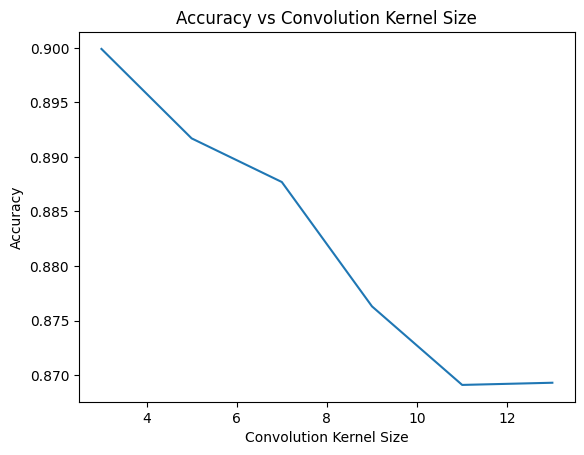

In [ ]:
conv_kernel_sizes = [3, 5, 7, 9, 11, 13]
accuracy_scores = []

for conv_kernel_size in conv_kernel_sizes:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=conv_kernel_size,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution kernel size {conv_kernel_size}: {accuracy * 100}%')

max_conv_kernel_size = conv_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution kernel size: {max_conv_kernel_size}')

plt.plot(conv_kernel_sizes, accuracy_scores)
plt.xlabel('Convolution Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Kernel Size')
plt.show()

Epoch 1/10, Loss: 0.35166311264038086
Epoch 2/10, Loss: 0.45234084129333496
Epoch 3/10, Loss: 0.26503193378448486
Epoch 4/10, Loss: 0.25175631046295166
Epoch 5/10, Loss: 0.2590104639530182
Epoch 6/10, Loss: 0.5360004901885986
Epoch 7/10, Loss: 0.1829146444797516
Epoch 8/10, Loss: 0.36421751976013184
Epoch 9/10, Loss: 0.09700894355773926
Epoch 10/10, Loss: 0.2487829476594925
Accuracy with convolution stride 1: 0.8975
Epoch 1/10, Loss: 0.592214822769165
Epoch 2/10, Loss: 0.33037805557250977
Epoch 3/10, Loss: 0.33971738815307617
Epoch 4/10, Loss: 0.307239830493927
Epoch 5/10, Loss: 0.3028284013271332
Epoch 6/10, Loss: 0.4542357623577118
Epoch 7/10, Loss: 0.2104647159576416
Epoch 8/10, Loss: 0.1844804584980011
Epoch 9/10, Loss: 0.38598379492759705
Epoch 10/10, Loss: 0.27486473321914673
Accuracy with convolution stride 2: 0.8726
Epoch 1/10, Loss: 0.503080427646637
Epoch 2/10, Loss: 0.6684353351593018
Epoch 3/10, Loss: 0.4624493718147278
Epoch 4/10, Loss: 0.3064733147621155
Epoch 5/10, Loss:

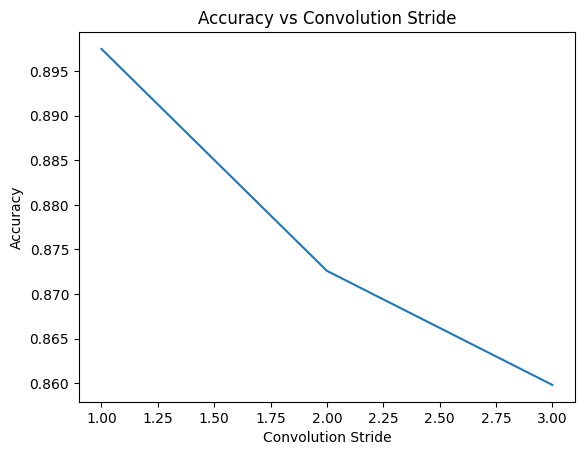

In [ ]:
conv_strides = [1, 2, 3]
accuracy_scores = []

for conv_stride in conv_strides:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=conv_stride,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution stride {conv_stride}: {accuracy}')

max_conv_stride = conv_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution stride: {max_conv_stride}')

plt.plot(conv_strides, accuracy_scores)
plt.xlabel('Convolution Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Stride')
plt.show()

Epoch 1/10, Loss: 0.34836599230766296
Epoch 2/10, Loss: 0.5233832597732544
Epoch 3/10, Loss: 0.44753432273864746
Epoch 4/10, Loss: 0.12829765677452087
Epoch 5/10, Loss: 0.32064878940582275
Epoch 6/10, Loss: 0.13633449375629425
Epoch 7/10, Loss: 0.33740705251693726
Epoch 8/10, Loss: 0.28809183835983276
Epoch 9/10, Loss: 0.20358923077583313
Epoch 10/10, Loss: 0.2576639950275421
Accuracy with pool kernel size 2: 0.8959
Epoch 1/10, Loss: 0.4213646650314331
Epoch 2/10, Loss: 0.5155596137046814
Epoch 3/10, Loss: 0.18080337345600128
Epoch 4/10, Loss: 0.15275856852531433
Epoch 5/10, Loss: 0.34785619378089905
Epoch 6/10, Loss: 0.2647726535797119
Epoch 7/10, Loss: 0.2344876229763031
Epoch 8/10, Loss: 0.10612528026103973
Epoch 9/10, Loss: 0.2403622567653656
Epoch 10/10, Loss: 0.14198273420333862
Accuracy with pool kernel size 3: 0.8965
Epoch 1/10, Loss: 0.2759730815887451
Epoch 2/10, Loss: 0.5504245758056641
Epoch 3/10, Loss: 0.5063107013702393
Epoch 4/10, Loss: 0.49630770087242126
Epoch 5/10, Lo

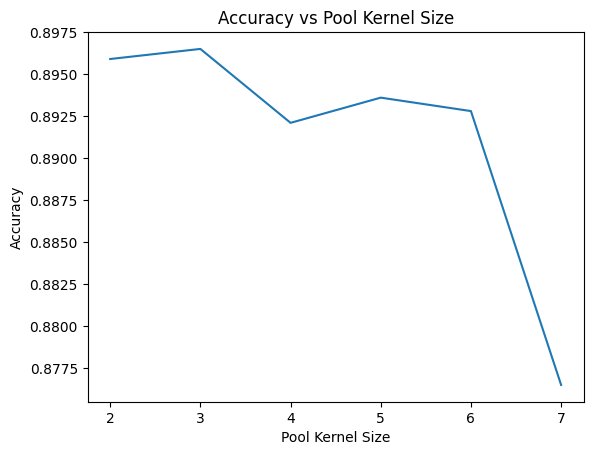

In [ ]:
pool_kernel_sizes = [2, 3, 4, 5, 6, 7]
accuracy_scores = []

for pool_kernel_size in pool_kernel_sizes:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=pool_kernel_size,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool kernel size {pool_kernel_size}: {accuracy}')

max_pool_kernel_size = pool_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool kernel size: {max_pool_kernel_size}')

plt.plot(pool_kernel_sizes, accuracy_scores)
plt.xlabel('Pool Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Kernel Size')
plt.show()

Epoch 1/10, Loss: 0.3736293613910675
Epoch 2/10, Loss: 0.35237327218055725
Epoch 3/10, Loss: 0.32247164845466614
Epoch 4/10, Loss: 0.46239739656448364
Epoch 5/10, Loss: 0.49718236923217773
Epoch 6/10, Loss: 0.4615614116191864
Epoch 7/10, Loss: 0.23187151551246643
Epoch 8/10, Loss: 0.49742621183395386
Epoch 9/10, Loss: 0.2970583140850067
Epoch 10/10, Loss: 0.12496576458215714
Accuracy with pool stride 1: 0.9022
Epoch 1/10, Loss: 0.5944217443466187
Epoch 2/10, Loss: 0.24829193949699402
Epoch 3/10, Loss: 0.43123453855514526
Epoch 4/10, Loss: 0.2065914273262024
Epoch 5/10, Loss: 0.46310171484947205
Epoch 6/10, Loss: 0.3678034543991089
Epoch 7/10, Loss: 0.250759482383728
Epoch 8/10, Loss: 0.5129427909851074
Epoch 9/10, Loss: 0.15602520108222961
Epoch 10/10, Loss: 0.17376819252967834
Accuracy with pool stride 2: 0.8905
Epoch 1/10, Loss: 0.3379647135734558
Epoch 2/10, Loss: 0.41029825806617737
Epoch 3/10, Loss: 0.37060171365737915
Epoch 4/10, Loss: 0.37610843777656555
Epoch 5/10, Loss: 0.3580

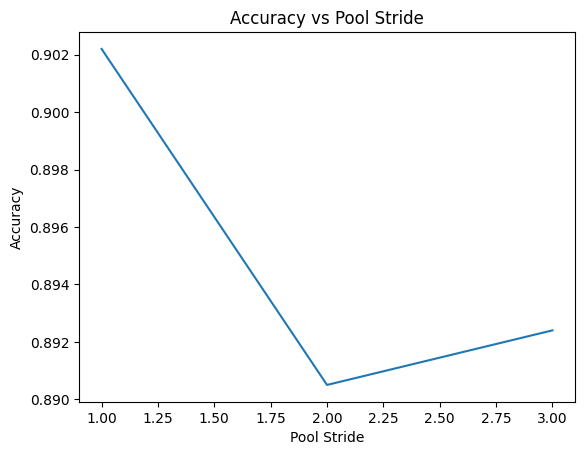

In [ ]:
pool_strides = [1, 2, 3]
accuracy_scores = []

for pool_stride in pool_strides:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=max_pool_kernel_size,
                   stride_pool=pool_stride,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool stride {pool_stride}: {accuracy}')

max_pool_stride = pool_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool stride: {max_pool_stride}')

plt.plot(pool_strides, accuracy_scores)
plt.xlabel('Pool Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Stride')
plt.show()

Epoch 1/10, Loss: 0.5205774307250977
Epoch 2/10, Loss: 0.24920785427093506
Epoch 3/10, Loss: 0.21215815842151642
Epoch 4/10, Loss: 0.18700698018074036
Epoch 5/10, Loss: 0.1520395427942276
Epoch 6/10, Loss: 0.18340852856636047
Epoch 7/10, Loss: 0.512304425239563
Epoch 8/10, Loss: 0.398642897605896
Epoch 9/10, Loss: 0.14748218655586243
Epoch 10/10, Loss: 0.24669094383716583
Accuracy with learning rate 0.3: 89.60000000000001%
Epoch 1/10, Loss: 0.40687334537506104
Epoch 2/10, Loss: 0.17667406797409058
Epoch 3/10, Loss: 0.12254570424556732
Epoch 4/10, Loss: 0.3381783366203308
Epoch 5/10, Loss: 0.07435144484043121
Epoch 6/10, Loss: 0.3994900584220886
Epoch 7/10, Loss: 0.19354814291000366
Epoch 8/10, Loss: 0.6768141388893127
Epoch 9/10, Loss: 0.010719005018472672
Epoch 10/10, Loss: 0.042578525841236115
Accuracy with learning rate 0.1: 91.19%
Epoch 1/10, Loss: 0.647742509841919
Epoch 2/10, Loss: 0.28252631425857544
Epoch 3/10, Loss: 0.2702483832836151
Epoch 4/10, Loss: 0.18106116354465485
Epoc

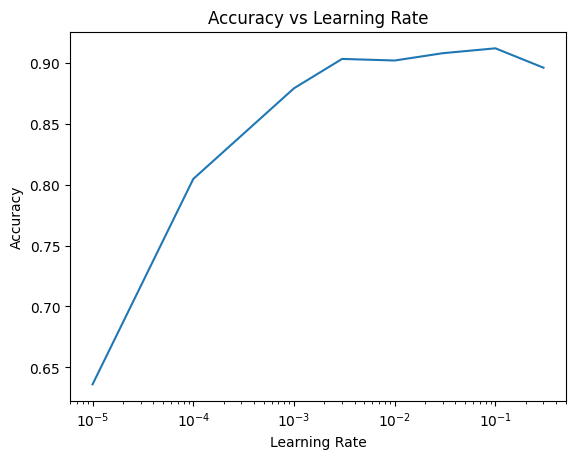

In [ ]:
lrs = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0001, 0.00001]
accuracy_scores = []

for lr in lrs:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=max_pool_kernel_size,
                   stride_pool=max_pool_stride,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=lr, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with learning rate {lr}: {accuracy * 100}%')

max_lr = lrs[accuracy_scores.index(max(accuracy_scores))]
print(f'Best learning rate: {max_lr}')

plt.plot(lrs, accuracy_scores)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]
accuracy_scores = []

for batch_size in batch_sizes:
    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=max_pool_kernel_size,
                   stride_pool=max_pool_stride,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=max_lr, batch_size=batch_size, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with batch size {batch_size}: {accuracy * 100}%')

max_batch_size = batch_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best batch size: {max_batch_size}')

plt.plot(batch_sizes, accuracy_scores)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')
plt.show()

NameError: name 'ResNet' is not defined

In [ ]:
epoch_options = [5, 10, 15, 20, 25]
best_acc = 0
best_epoch = 0
accuracy_scores = []

print(f'Block: {max_block.__name__}')
print(f'Block count: {max_block_count}')
print(f'Linear layer count: {max_lin_layer_count}')
print(f'Convolution kernel size: {max_conv_kernel_size}')
print(f'Convolution stride: {max_conv_stride}')
print(f'Pool kernel size: {max_pool_kernel_size}')
print(f'Pool stride: {max_pool_stride}')
print(f'Learning rate: {max_lr}')
print(f'Batch size: {max_batch_size}\n')

for epochs in epoch_options:
    print(f'Testing epochs: {epochs}')

    model = ResNet(in_channels=1,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=max_pool_kernel_size,
                   stride_pool=max_pool_stride,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to('cuda')
    model.fit(train_x, train_y, lr=max_lr, batch_size=max_batch_size, epochs=epochs)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()
        acc = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(acc)
        print(f'Accuracy: {acc * 100:.2f}%\n')

        if acc > best_acc:
            best_acc = acc
            best_epoch = epochs
            best_model = model

print(f'Best epoch count: {best_epoch}, accuracy: {best_acc * 100:.2f}%')
